# CS 4496/7496 Character Animation (Fall 2023)
Copyright (c) Georgia Institute of Technology

---


# Project 2: Integrators (due <font color='red'>10/6/2023</font>, 11:59PM)

**Tip:** *This notebook contains many long cells, most of which you should not edit (but would still need to run). Use the "Table of contents" pane on the left of your Colab window to navigate cells quickly.*

![The Leaning Tower of Pisa, Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/The_Leaning_Tower_of_Pisa_SB.jpeg/340px-The_Leaning_Tower_of_Pisa_SB.jpeg)

You are standing at the top of the Leaning Tower of Pisa. Just like Galileo, you are trying to convince people that your numerical integrators are accurate by dropping balls with equal mass from the tower. One ball follows the analytical equation of free-fall motion while the others are simulated by your solvers.

In your program, you will implement the analytical solution and four numerical integration methods: Explicit Euler, Midpoint, RK4 and Implicit Euler. Show that two of them yield the same motion as the analytical solution, while the other two do not.

In your results, you will show five objects (of different colors representing the different methods) side-by-side, falling from the same height at the same time with zero initial velocity.

Skeleton code for visualization has already been provided.

PyBullet documentation (if you want to learn more about the physics engine used for these simulations): https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#

Note: the installation of PyBullet will take a few minutes...

In [1]:
# Install pybullet and related requirements
!pip install https://pybullet.org/download/pybullet-3.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install pybullet==2.6.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-2.6.5-cp310-cp310-linux_x86_64.whl size=101474504 sha256=eb834eb97740ff05b53c69dc0209ba2410327912b69e505870704b5d35896bc5
  Stored in directory: /root/.cache/pip/wheels/ee/64/09/b01fdf51b550cca64866a88b97315fe48a437036adc66a9d6d
Successfully built pybullet
  Attempting uninstall: pybullet
    Found existing installation: pybullet 3.2.5
    Uninstalling pybullet-3.2.5:
      Successfully uninstalled pybullet-3.2.5


# 1. Skeleton code (do not edit)

### 1.1. Import required libraries

In [2]:
import pybullet as p
import pybullet_data as pd
import time
import io
import imageio
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np

### 1.2. Create base class for dynamic systems

In [3]:
class DynamicSystem(object):
  """ An abstract dynamic system. All systems we use will inherit from this class.
  """

  # ** Basic state operations **

  def __init__(self, initial_state):
    self.set_state(initial_state)

  def get_dim(self):
    '''Get the dimensionality (number of variables) in the system's state.'''
    return len(self.state)

  def get_system_state(self):
    return self.state

  def set_state(self, state):
    self.state = np.array(state)

  # ** Simulation operations **

  def on_start_simulation(self):
    raise NotImplementedError

  def on_step_simulation(self):
    raise NotImplementedError

  # ** Analytical solution **

  def analytical_state_update(self, t):
    raise NotImplementedError

  # ** Operations for numerical integration **

  def get_system_derivative(self):
    raise NotImplementedError

  def get_gradient_of_system_derivative(self):
    raise NotImplementedError

### 1.3. Create base class for numerical integrators (i.e. solvers)

In [4]:
class Solver(object):
  """An abstract solver (numerical integrator), which all solvers inherit from."""
  def __init__(self):
    """Initilializes the solver."""
    pass

  def step(self, h: float, system: DynamicSystem):
    """Calculate the state after advancement by `h` from its current state, and use `set_state()` to update the system.
    Do not return anything.

    Since nothing about this abstract solver is known, we raise an error.
    """
    raise NotImplementedError


### 1.4. Simulation utilities

#### PyBullet general initialization

In [5]:
# PyBullet globals
flags = p.URDF_INITIALIZE_SAT_FEATURES

def init_pybullet():
  '''Initialize PyBullet parameters (call before setting up any PyBullet simulation)'''
  global flags
  p.connect(p.DIRECT)
  p.setAdditionalSearchPath(pd.getDataPath())
  p.resetSimulation()

  p.loadURDF('plane.urdf', [0, 0, 0], flags=flags, useFixedBase=True) # create plane in background

#### PyBullet camera setup

In [6]:
# Camera settings (global)
pixelWidth, pixelHeight = 640, 360
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 5.0], distance=10.0, yaw=0.0, pitch=0.0, roll=0.0, upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov=60, aspect=pixelWidth / pixelHeight, nearVal=0.01, farVal=100)

def render_pybullet():
  '''Render image from global camera in pybullet'''
  global pixelWidth, pixelHeight, viewMatrix, projectionMatrix
  _, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix, projectionMatrix, shadow=1, lightDirection=[1,1,1])
  return img[..., :3]   # ignore alpha

# 2. Galileo's experiment: Free-fall system

### System definition

The first task is to write the code for defining the "system" of each free-falling object. Particularly, you need to implement the following functions:
- `get_system_derivative()`, which returns the derivative of the current state.
- `analytical_state_update()`, which sets the correct state at any time `t` as computed analytically, and doesn't return anything.
  - Use the closed-form solution for free-fall height and velocity as a function of time.

Please note that we have an additional function for extra questions `get_gradient_of_system_derivative()`, which returns the gradient of the derivative at the current state. This will be used for implicit Euler (see the docstring for details). You do **NOT** need to implement this for regular problems.

In the cell below (and in all cells where you need to write code), your code goes under the `#Student answer begins` comments.

**<font color='orange'> \*\*Task 1: Write your code below (20 pts)\*\* </font>**



In [7]:
class Freefall(DynamicSystem):
  """ A dynamic system of a freefall object, simulated using pybullet.
  """
  def __init__(self, initial_height: float, gravity: float):
    """Initialize the object that is free-falling (assumed to be of mass 1).

    Args:
      initial_height: the initial height (velocity starts at zero for freefall)
      g: the gravity constant
    """
    super().__init__(initial_state=(initial_height, 0.0))
    self.initial_height = initial_height
    self.gravity = gravity

  # ** Simulation operations **

  def on_start_simulation(self, rgbaColor, basePosition):
    """To be called when a simulation for this system (pybullet) is about to start.
    Sets up the pybullet object for this system (a free-falling sphere)
    """
    global flags
    objShape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=rgbaColor)
    self.obj = p.createMultiBody(baseMass=1, baseVisualShapeIndex=objShape, basePosition=basePosition, flags=flags)

  def on_step_simulation(self):
    """To be called when a simulation for this system (pybullet) is stepping through.
    Updates the position and velocity of the object for visualization.
    """
    obj = self.obj
    x, y, _ = p.getBasePositionAndOrientation(obj)[0]
    z, dz = self.state
    p.resetBasePositionAndOrientation(obj, posObj=[x, y, z], ornObj=[0, 0, 0, 1])
    p.resetBaseVelocity(obj, linearVelocity=[0, 0, dz])


  # ** Analytical solution **

  def analytical_state_update(self, t):
    """Set the state to the analytical solution of the system at time t (float).
    Args:
      t: The given simulation time
    """
    # Student answer begins
    z = self.initial_height - (1/2) * self.gravity * (t ** 2)
    dz = (self.gravity * -1) * t
    self.set_state((z, dz))
    # Student answer ends

  # ** Operations for numerical integration **

  def get_system_derivative(self):
    """Returns the derivative of the given system at its current state as a np.array.
    Used in all numerical integration methods. It is the function ` f ` in the slides.
    For example, if the state is [a,b], then this returns [a*, b*] where a* = da/dt and b* = db/dt.

    Returns:
      The derivative of the given system as a np.array of shape (2,)
    """
    # Student answer begins
    x, v = self.state
    dx = v
    dv = (self.gravity * -1)
    return np.array([dx, dv])
    # Student answer ends

  def get_gradient_of_system_derivative(self):
    """Returns the gradient of `get_system_derivative()` (Hessian) of the given system at its current state as a np.array.
    Used in first-order implicit Euler. It is the function ` f' ` used in the Taylor series expansion in the slides.
    For example, if the state is [a,b] with derivative [a*, b*], then this returns:
    gradient([a*, b*]) = [ [ d(a*)/da, d(a*)/db ],
                           [ d(b*)/da, d(b*)/db ] ]

    Returns:
      The gradient of the derivative of the given system as a np.array of shape (2, 2)
    """
    # Student answer begins - for the extra question (implicit Euler)
    return np.array([
        [0.0, 1.0],
        [0.0, 0.0]
    ])
    # Student answer ends


Let's quickly verify your implementation. (do not edit)

In [22]:
system = Freefall(initial_height=10.0, gravity=9.8) # 10m, zero velocity
assert np.allclose(system.get_system_derivative(), np.array([0.0, -9.8]))

system.set_state((5.0, -1.0)) # 5.0m, -1.0m/s
assert np.allclose(system.get_system_derivative(), np.array([-1.0, -9.8]))

system.analytical_state_update(0.0)
assert np.allclose(system.get_system_state(), np.array([10.0, 0.0]))
system.analytical_state_update(0.5)
assert np.allclose(system.get_system_state(), np.array([8.775, -4.9]))
system.analytical_state_update(1.0)
assert np.allclose(system.get_system_state(), np.array([5.1, -9.8]))

print("You pass the tests!")

You pass the tests!


### Integrator definitions

Now it is time for you to implement the integrators.

The integrators have to work for dynamic systems *in general* - not just for this kind of system! In other words, don't assume that the system you get as input will always be a free-fall system. Later in this notebook, another system will be introduced and your integrators will be tested against that one too.

For implementing all integrators, follow the same pattern:
1. Get any state/derivative/gradient info you need from the provided `system`
1. Compute the state after advancement by time `h` from the current state
1. Update the system's state using `set_state()`, and don't return anything.

Note that, to compute the state after advancement by `h`, you might need to use some intermediate states and store info from them.

#### Explicit Euler method

To implement this, you shouldn't need to use any intermediate states.

**<font color='orange'> \*\*Task 2: Write your code below (10 pts)\*\* </font>**

In [23]:
class ExplicitEulerSolver(Solver):
  """A general Explicit Euler method solver."""
  def step(self, h: float, system: DynamicSystem):
    """ Read the current system state, calculate the state after advancement by `h`, and use `set_state()` to update the system. Do not return anything.

    Args:
      system: the instance of the given dynamic system
      h: an amount of the time step we want to integrate
    """
    # Student answer begins
    # useful functions: system.get_system_state, system.get_system_derivative, and system.set_state

    x0 = system.get_system_state()
    x_derivative = system.get_system_derivative()
    next_state = x0 + (h * x_derivative)
    system.set_state(next_state)

    # Student answer ends

#### Midpoint method

*Hint:* compute $x_{mid}$, use that to set an intermediate state for the system, and then compute $f_{mid}$ from there. Don't forget to store the original state $x_0$.

**<font color='orange'> \*\*Task 3: Write your code below (10 pts)\*\* </font>**

In [27]:
class MidpointSolver(Solver):
  """A general Midpoint method solver."""
  def step(self, h: float, system: DynamicSystem):
    """ Read the current system state, calculate the state after advancement by `h`, and use `set_state()` to update the system. Do not return anything.

    Args:
      system: the instance of the given dynamic system
      h: an amount of the time step we want to integrate
    """
    # Student answer begins
    # useful functions: system.get_system_state, system.get_system_derivative, and system.set_state

    x0 = system.get_system_state()
    x_derivative = system.get_system_derivative()
    euler_step = h * x_derivative
    f_mid = x0 + (euler_step / 2)
    system.set_state(f_mid)
    x_derivative = system.get_system_derivative()
    next_state = x0 + (h * x_derivative)
    system.set_state(next_state)

    # Student answer ends

#### Runge-Kutta method (RK4)

*Hint:* follow the RK4 equations and use multiple intermediate states. Observe that $k_1$ is taken from the derivative of state $x_0$, $k_2$ from $x_1$ and so on. You should end up using 4 `get_system_derivative()` calls.

**<font color='orange'> \*\*Task 4: Write your code below (10 pts)\*\* </font>**

In [25]:
class RK4Solver(Solver):
  """A general RK4 solver."""
  def step(self, h: float, system: DynamicSystem):
    """ Read the current system state, calculate the state after advancement by `h`, and use `set_state()` to update the system. Do not return anything.

    Args:
      system: the instance of the given dynamic system
      h: an amount of the time step we want to integrate
    """
    # Student answer begins
    # useful functions: system.get_system_state, system.get_system_derivative, and system.set_state

    x0 = system.get_system_state()
    k1 = h * system.get_system_derivative()
    system.set_state(x0 + k1 / 2)
    k2 = h * system.get_system_derivative()
    system.set_state(x0 + k2 / 2)
    k3 = h * system.get_system_derivative()
    system.set_state(x0 + k3)
    k4 = h * system.get_system_derivative()
    next_state = x0 + (1/6) * k1 + (1/3) * k2 + (1/3) * k3 + (1/6) * k4
    system.set_state(next_state)

    # Student answer ends

#### Testing all integrators for free-fall (do not edit)

In [28]:
test_systems = [Freefall(100.0, 10.0) for _ in range(3)]
test_solvers = [ExplicitEulerSolver(), MidpointSolver(), RK4Solver()]
h = 1.

for _ in range(3):
  for system, solver in zip(test_systems, test_solvers):
    solver.step(h,system)

assert np.allclose(
  np.stack([system.get_system_state() for system in test_systems], axis=0),
  [
    [ 70., -30.],
    [ 55., -30.],
    [ 55., -30.],
  ]
)

for _ in range(7):
  for system, solver in zip(test_systems, test_solvers):
    solver.step(h,system)

assert np.allclose(
  np.stack([system.get_system_state() for system in test_systems], axis=0),
  [
    [-350., -100.],
    [-400., -100.],
    [-400., -100.],
  ]
)

print('You passed all the tests!')

You passed all the tests!


### Simulation & Comparison of Methods

Now, we'll be simulating 5 free-fall systems which are identical except for the method used to update state. We'll visualize the trajectories we get and compare the methods.

#### Load PyBullet objects and initialize required parameters (do not edit)

In [29]:
init_pybullet()

initial_height = 10.0
g = 9.8  # Acceleration due to gravity
h = 1. / 20.  # Time step

# Order of methods (and corresponding systems)
method_labels = {
  0: 'Analytical solution',
  1: 'Explicit Euler method',
  2: 'Midpoint method',
  3: 'RK4 method',
}

# Construct all the systems
systems = [Freefall(initial_height, g) for _ in range(len(method_labels))]

# Load objects

# Red Sphere - Analytical
systems[0].on_start_simulation(rgbaColor=[1, 0, 0, 1], basePosition=[ -2.0, 0.0, initial_height])
# Green sphere - Explicit Euler
systems[1].on_start_simulation(rgbaColor=[0, 1, 0, 1], basePosition=[ -1.0, 0.0, initial_height])
# Blue sphere - Midpoint
systems[2].on_start_simulation(rgbaColor=[0, 0, 1, 1], basePosition=[0.0, 0.0, initial_height])
# Purple sphere - RK4
systems[3].on_start_simulation(rgbaColor=[0.5, 0, 0.5, 1], basePosition=[1.0, 0.0, initial_height])

#### Complete the system update steps in the `while` loop below for all the systems in the `systems` array.

They are in the order defined in the cell above (refer to the `method_labels` variable).

Note that one system needs to update itself analytically using `analytical_state_update()` while the others need to be updated by `Solver` objects.

**<font color='orange'> \*\*Task 5: Write your code below (20 pts)\*\* </font>**

In [30]:
def get_heights(systems):
  """A helper function that returns the heights of all systems."""
  return [s.get_system_state()[0] for s in systems]

i, t = 0, 0.  # Loop counter, Time
heightsToPlot = [[initial_height] for _ in range(len(systems))]
times = [t]

# Constructs all the solvers
explicit_euler_solver = ExplicitEulerSolver()
midpoint_solver = MidpointSolver()
rk4_solver = RK4Solver()

frames = []
while max(get_heights(systems)) > 0.0:
  t += h

  # Update the systems using the methods you just implemented.

  # Student answer begins

  systems[0].analytical_state_update(t)  # A bit special treatment for analytical update.
  # How do you move explicit_euler_solver, midpoint_solver, and rk4_solver forward? Use step functions.
  explicit_euler_solver.step(h, systems[1])
  midpoint_solver.step(h, systems[2])
  rk4_solver.step(h, systems[3])

  # Student answer ends

  heights = get_heights(systems)

  # Print the values for debugging.
  if i % 5 == 0:
      print("At time t = {}".format(t))
      for idx, label in method_labels.items():
        print("Height of object using {} = {}".format(label, heights[idx]))

  # Update the values for plot and visualization
  for j, system_j in enumerate(systems):
    system_j.on_step_simulation()
    heightsToPlot[j].append(heights[j])

  # Render image
  frames.append(render_pybullet())

  times.append(t)
  i += 1

print("Done. t = {}".format(t))

At time t = 0.05
Height of object using Analytical solution = 9.98775
Height of object using Explicit Euler method = 10.0
Height of object using Midpoint method = 9.98775
Height of object using RK4 method = 9.987749999999998
At time t = 0.3
Height of object using Analytical solution = 9.559
Height of object using Explicit Euler method = 9.6325
Height of object using Midpoint method = 9.559
Height of object using RK4 method = 9.559000000000001
At time t = 0.5499999999999999
Height of object using Analytical solution = 8.51775
Height of object using Explicit Euler method = 8.652500000000002
Height of object using Midpoint method = 8.51775
Height of object using RK4 method = 8.517750000000001
At time t = 0.8000000000000002
Height of object using Analytical solution = 6.863999999999999
Height of object using Explicit Euler method = 7.0600000000000005
Height of object using Midpoint method = 6.863999999999998
Height of object using RK4 method = 6.8640000000000025
At time t = 1.0500000000000

#### Let's visualize the results of the experiments. (do not edit)

Make sure that you can see the animation of five free-falling objects.
You may want to download the gif for repeating animation.

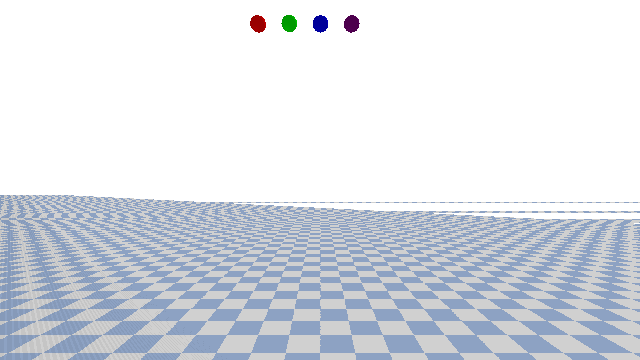

In [31]:
freefall_gif_path = './test_freefall.gif'

imageio.mimsave(freefall_gif_path, np.stack(frames, axis=0), 'GIF', duration=1.0)
ipythondisplay.Image(filename=freefall_gif_path)

#### Let us also look at the plot of heights vs time. (do not edit)

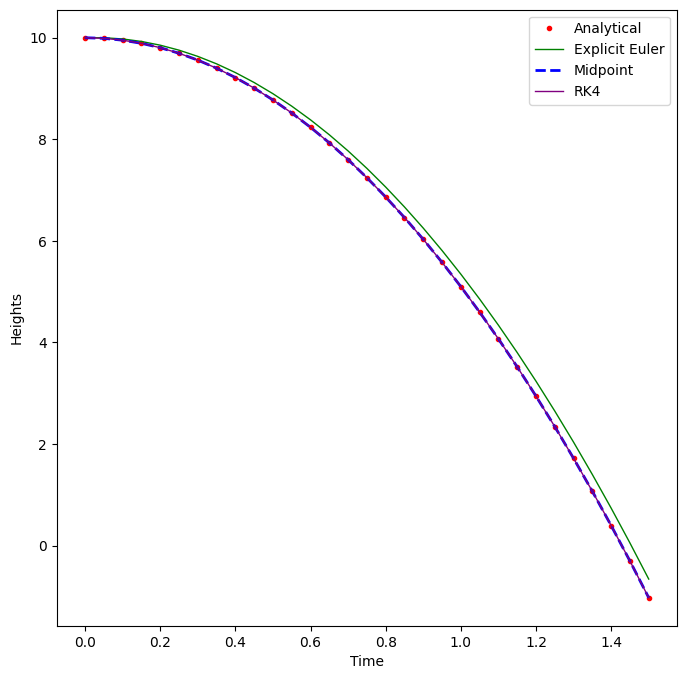

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.plot(times, heightsToPlot[0], 'r.', lw=4, label='Analytical')
plt.plot(times, heightsToPlot[1], 'g-', lw=1, label='Explicit Euler')
plt.plot(times, heightsToPlot[2], 'b--', lw=2, label='Midpoint')
plt.plot(times, heightsToPlot[3], color='purple', ls='-', lw=1, label='RK4')
plt.xlabel('Time')
plt.ylabel('Heights')
plt.legend()
plt.show()

Can you see all the height trajectories over time?

Discuss the results, particularly in terms of the accuracy of each method.

Will the results be different if we take a smaller/larger time step?

**<font color='orange'> \*\*Task 6: Write your answer below (10 pts)\*\* </font>**

I can see all the height trajectories over time. In regards to the results, the explicit euler method does not seem to accurate like the other 3 systems as the height is slightly higher than the rest. The results will be different if we take a smaller time step since explicit euler is a first order method and can be more accurate with a smaller time step while having a larger time step could make the system unstable.



# 3. Bead-on-wire system

As promised, you will now test your integrators on a new system - the 2D bead-on-wire system from class, generalized to follow these differential equations:
$$
\frac{dx}{dt} = -k_x x; \frac{dy}{dt} = -k_y y
$$
with general initial conditions.

The system definition and visualization code has been implemented for you.

You just need to verify that the integrators work without any changes, and write your observations from the simulation.

### System definition (do not edit)

In [33]:
class BeadOnWire(DynamicSystem):
  """ A dynamic system of a bead on a wire moving in 2D, simulated using matplotlib.
  """
  def __init__(self, initial_state, kx, ky):
    """state is of form (x,y)"""
    super().__init__(initial_state)
    self.initial_state = initial_state
    self.k = np.array([kx, ky])

  # ** Simulation operations **

  def on_start_simulation(self, line):
    self.history = [self.initial_state]
    self.line = line
    self.line.set_data([], [])

  def on_step_simulation(self):
    self.history.append(self.state)
    x_values, y_values = np.array(self.history).T
    self.line.set_data(x_values, y_values)

  # ** Analytical solution **

  def analytical_state_update(self, t):
    state = self.initial_state * np.exp(-self.k * t)
    self.set_state(state)

  # ** Operations for numerical integration **

  def get_system_derivative(self):
    return -self.k * self.state

  def get_gradient_of_system_derivative(self):
    return np.diag(-self.k)

### Testing all integrators for bead-on-wire (do not edit)

In [34]:
test_systems = [BeadOnWire((1.0, 1.0), 1.0, 5.0) for _ in range(3)]
test_solvers = [ExplicitEulerSolver(), MidpointSolver(), RK4Solver()]
h = 1. / 4.

for _ in range(2):
  for system, solver in zip(test_systems, test_solvers):
    solver.step(h,system)

assert np.allclose(
  np.stack([system.get_system_state() for system in test_systems], axis=0),
  [
    [0.5625, 0.0625],
    [0.61035156, 0.28222656],
    [0.60654283, 0.09452822],
  ]
)

for _ in range(6):
  for system, solver in zip(test_systems, test_solvers):
    solver.step(h,system)

assert np.allclose(
  np.stack([system.get_system_state() for system in test_systems], axis=0),
  [
    [1.00112915e-01, 1.52587891e-05],
    [0.13877788, 0.00634441],
    [1.35346142e-01, 7.98446841e-05],
  ]
)

print('You passed all the tests!')

You passed all the tests!


### Simulation & visualization with matplotlib

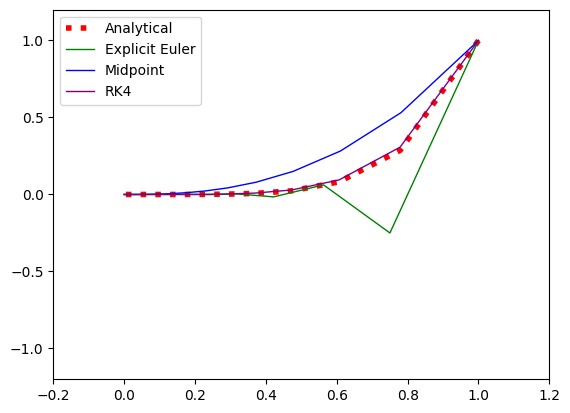

In [38]:
# Simulation parameters
h = 1. / 4.
numTimeSteps = 50
initial_state, kx, ky = (1.0, 1.0), 1.0, 5.0

# Systems & solvers
systems = [BeadOnWire(initial_state, kx, ky) for _ in range(4)]
solvers = [None, ExplicitEulerSolver(), MidpointSolver(), RK4Solver()]

method_data = {
  0: ('red', 'Analytical'),
  1: ('green', 'Explicit Euler'),
  2: ('blue', 'Midpoint'),
  3: ('purple', 'RK4'),
}

# Figure setup
from matplotlib import animation, rc

fig, ax = plt.subplots()
ax.set_xlim((-0.2, 1.2))
ax.set_ylim((-1.2, 1.2))

lines = [None] * len(systems)
lines_non_null = []
for idx, (color, label) in method_data.items():
  kwargs = {'ls': ':', 'lw': 4} if idx == 0 else {'lw': 1}
  line = ax.plot([], [], color=color, label=label, **kwargs)[0]
  lines[idx] = line
  lines_non_null.append(line)

# Initialization function: plot the background of each frame
def init():
  for idx in method_data:
    systems[idx].on_start_simulation(lines[idx])
  return lines_non_null

# Animation function. This is called sequentially
def animate(i):
  for idx in method_data:
    system, solver = systems[idx], solvers[idx]
    if solver is None:
      system.analytical_state_update(i*h)
    else:
      solver.step(h,system)
    system.on_step_simulation()

  ax.legend()
  return lines_non_null

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=numTimeSteps, interval=50, blit=True)
HTML(anim.to_html5_video())

In the cell above, observe the output under 2 scenarios:
1.   The original settings (i.e. run the cell as-is)
2.   With a larger time step, `h = 1. / 2.`.

Describe the behavior that each integrator exhibits in each case, specifically with regard to:
1. simulation accuracy (how closely does the solver match the analytical solution, in comparison to the other integrators?)
1. stability (can you observe any fluctuations of state, and is the trajectory converging or exploding?)

**<font color='orange'> \*\*Write your code below (20 pts)\*\* </font>**

When the time step is smaller (1. / 4.), RK4 is verry accurate with the analytical solution and midpoint method's trajectory is slightly higher than the analytical solution and explicit euler's trajectory goes below the analytical solution then rejoins the expected trajectory. The stability appears to be good for all the integrators. When the time step is larger (1. / 2.), RK4's trajectory becomes higher than analytical but rejoins the trajectory at the end and midpoint and explicit euler has a completely different trajectory than analytical. Also, it appears that midpoint and explicit euler are no longer stable because the time step is too large.

# 4. Extra Questions

## 4.1 Implicit Euler (first order) method

Please implement the implicit Eulier method. You may directly modify the above sections to implement the implicit Euler solver and visualize a new trajectory (with five balls).

*Hint:* follow the implicit Euler equations and make use of `get_gradient_of_system_derivative()`.

Useful Numpy functions: `np.eye()`, `np.linalg.inv()`

**<font color='orange'> \*\*Write your code below (4 pts)\*\* </font>**

## 4.2. Trapezoidal rule integrator: bead-on-wire

You know the drill by now. Implement another solver, one which uses the trapezoidal rule.

This time, refer to the trapezoidal rule equation from class and derive the final state update equation before coding it up in this cell. It will be visualized using the bead-on-wire system.

*Hint:* you must implement the implicit Euler solver before this question.


**<font color='orange'> \*\*Write your code below (3 pts)\*\* </font>**

In [20]:
class TrapezoidalSolver(Solver):
  """A general Trapezoidal Rule based solver."""
  def step(self, h: float, system: DynamicSystem):
    """ Read the current system state, calculate the state after advancement by `h`, and use `set_state()` to update the system. Do not return anything.

    Args:
      system: the instance of the given dynamic system
      h: an amount of the time step we want to integrate
    """
    # Student answer begins

    # Student answer ends

### Simulation & visualization with matplotlib (do not edit)

We now compare the trapezoidal solver with the analytical solution as well as the explicit and implicit Euler methods.

Ensure that you get a curve in between those of the explicit and implicit Euler methods, which is also the closest of the three to the analytical solution.

In [21]:
# Simulation parameters
h = 1. / 4.
numTimeSteps = 50
initial_state, kx, ky = (1.0, 1.0), 1.0, 5.0

# Systems & solvers
systems = [BeadOnWire(initial_state, kx, ky) for _ in range(4)]
solvers = [None, ExplicitEulerSolver(), ImplicitEulerSolver(), TrapezoidalSolver()]

method_data = {
  0: ('red', 'Analytical'),
  1: ('green', 'Explicit Euler'),
  2: ('cyan', 'Implicit Euler'),
  3: ('black', 'Trapezoidal Rule'),
}

# Figure setup
from matplotlib import animation, rc

fig, ax = plt.subplots()
ax.set_xlim((-0.2, 1.2))
ax.set_ylim((-1.2, 1.2))

lines = [None] * len(systems)
lines_non_null = []
for idx, (color, label) in method_data.items():
  kwargs = {'ls': ':', 'lw': 4} if idx == 0 else {'lw': 1}
  line = ax.plot([], [], color=color, label=label, **kwargs)[0]
  lines[idx] = line
  lines_non_null.append(line)

# Initialization function: plot the background of each frame
def init():
  for idx in method_data:
    systems[idx].on_start_simulation(lines[idx])
  return lines_non_null

# Animation function. This is called sequentially
def animate(i):
  for idx in method_data:
    system, solver = systems[idx], solvers[idx]
    if solver is None:
      system.analytical_state_update(i*h)
    else:
      solver.step(h,system)
    system.on_step_simulation()

  ax.legend()
  return lines_non_null

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=numTimeSteps, interval=50, blit=True)
HTML(anim.to_html5_video())

NameError: ignored

## 4.3. Step doubling: free-fall

Write a variation of the `ExplicitEulerSolver` that uses step doubling *repeatedly until the error is low enough*, and *returns the next time step to use*.

You will see the results on the freefall system from before; simulation code has been implemented for you.

Specifically, do the following in the `step()` function below:
1. Compute the two candidte states `x_a` and `x_b` as seen in class
1. Compare the mean absolute error between them with the provided `error_tol` value.
1. *If error is within tolerance:*
  - Set the state to `x_b`
  - Return the current time step
1. *Otherwise:*
  - compute the new time step to use based on the formula learnt in class
  - *reset the system state* to what it was before this `step()` function was called
  - recursively call `step()` with the new time step.

**<font color='orange'> \*\*Write your code below (3 pts)\*\* </font>**

In [ ]:
class SDExplicitEulerSolver(Solver):
  """A general Explicit Euler method solver with recursive step doubling."""
  def step(self, h: float, system: DynamicSystem, error_tol: float):
    """ Read the current system state, calculate the state after advancement by `dt`, and use `set_state()` to update the system.
    Now, though, return the next time step to use, according to step doubling using `error_tol`."""
    # Student answer begins

    # Student answer ends

### Simulation code (do not edit)

#### Load PyBullet objects and initialize required parameters

In [ ]:
init_pybullet()

initial_height = 10.0
g = 9.8  # Acceleration due to gravity

h = 1.  # Time step - step doubling can edit this
error_tol = 1e-2

# Order of methods (and corresponding systems)
method_labels = {
  0: 'Analytical solution',
  1: 'Explicit Euler SD method',
}

# Construct all the systems
systems = [Freefall(initial_height, g) for _ in range(len(method_labels))]


# Load objects

# Red Sphere - Analytical
systems[0].on_start_simulation(rgbaColor=[1, 0, 0, 1], basePosition=[-1.0, 0.0, initial_height])
# Green sphere - Explicit Euler (SD)
systems[1].on_start_simulation(rgbaColor=[0, 1, 0, 1], basePosition=[ 1.0, 0.0, initial_height])

#### Simulation loop

In [ ]:
i, t = 0, 0.  # Loop counter, Time
heightsToPlot = [[initial_height] for _ in range(len(systems))]
times = [t]

# Constructs all the solvers
sd_solver = SDExplicitEulerSolver()

frames = []
while max(get_heights(systems)) > 0.0:
  h_new = sd_solver.step(h,systems[1], error_tol)
  if not np.isclose(h, h_new):
      print("\n** h changed by SD: {} -> {} **\n".format(h, h_new))
      if t == 0.0:
        # use this as test case
        assert np.isclose(h_new, 0.09035), "Failed test case for SD"

  t += h_new
  systems[0].analytical_state_update(t)

  heights = get_heights(systems)

  # Print the values for debugging.
  if i % 5 == 0:
      print("At time t = {}".format(t))
      for idx, label in method_labels.items():
        print("Height of object using {} = {}".format(label, heights[idx]))

  # Update the values for plot and visualization
  for j, system_j in enumerate(systems):
    system_j.on_step_simulation()
    heightsToPlot[j].append(heights[j])

  # Render image
  frames.append(render_pybullet())

  times.append(t)
  h = h_new
  i += 1

print("\nDone, passing your test case. t = {}".format(t))

#### Visualize the results

Make sure that you can see the animation of 2 free-falling objects, with the green one lagging behind the red one.

In [ ]:
sd_gif_path = './test_sd.gif'

imageio.mimsave(sd_gif_path, np.stack(frames, axis=0), 'GIF', fps=20.0)
ipythondisplay.Image(filename=sd_gif_path)

#### Heights vs time

This will look similar to the standard Explicit Euler plot from before.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.plot(times, heightsToPlot[0], 'r.', lw=4, label='Analytical')
plt.plot(times, heightsToPlot[1], 'g-', lw=1, label='Explicit Euler SD')
plt.xlabel('Time')
plt.ylabel('Heights')
plt.legend()
plt.show()